<a href="https://colab.research.google.com/github/adampotton/Group-3-gotta-catch-em-all-/blob/main/Model_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from PIL import Image
import random
import os
import csv
import shutil
from google.colab import drive
from sklearn.model_selection import train_test_split
import os
from torchvision.transforms import v2
from torch.optim.lr_scheduler import ReduceLROnPlateau
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
drive.mount('/content/drive')
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root_directory = "/content/drive/My Drive/PokemonData"

selected_subdirectory = "/content/drive/My Drive/SelectedPokemonData"

# Get a list of all folders in the PokemonData directory
all_folders = [f for f in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, f))]

# Select 10 random folders change

n = 20
selected_folders = random.sample(all_folders, n)
print(selected_folders)

# Remove directory so it doesnt fill up
shutil.rmtree(selected_subdirectory, ignore_errors=True)
# Create a subdirectory for selected folders if it doesn't exist
os.makedirs(selected_subdirectory, exist_ok=True)

# Copy selected folders to the subdirectory
for folder_name in selected_folders:
    src_folder_path = os.path.join(root_directory, folder_name)
    dest_folder_path = os.path.join(selected_subdirectory, folder_name)
    # Remove the destination folder if it exists
    if os.path.exists(dest_folder_path):
        shutil.rmtree(dest_folder_path)
    shutil.copytree(src_folder_path, dest_folder_path)
# Dictionary to store image arrays for selected folders
image_arrays_dict = {}

# Iterate over the selected folders in the subdirectory
for folder_name in selected_folders:
    folder_path = os.path.join(selected_subdirectory, folder_name)

# Define a common size for resizing images
common_size = (224, 224, 3)  # Common size for RGB images

# Loop through each folder in the root directory
for folder_name in os.listdir(selected_subdirectory):
    folder_path = os.path.join(selected_subdirectory, folder_name)
    if os.path.isdir(folder_path):
        image_arrays = []
        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".jpg", ".png")):
                image_path = os.path.join(folder_path, filename)
                img = Image.open(image_path).convert("RGB")  # Convert to RGB format
                img_resized = img.resize((common_size[1], common_size[0]), Image.ANTIALIAS)
                img_array = np.array(img_resized)
                image_arrays.append(img_array)
        image_arrays = np.array(image_arrays)
        image_arrays_dict[folder_name] = image_arrays

# Combine all image arrays into a single array
all_images = np.concatenate(list(image_arrays_dict.values()), axis=0)

images_per_class_dict = dict()
for folder_name, image_array in image_arrays_dict.items():
    print(f"Shape of the image array for folder '{folder_name}': {image_array.shape}")
    images_per_class_dict.update({folder_name: image_array.shape[0]})
pokemon_classes = list(images_per_class_dict.keys())
num_images_per_class = list(images_per_class_dict.values())
print(pokemon_classes)
print(num_images_per_class)

['Cloyster', 'Venonat', 'MrMime', 'Caterpie', 'Weedle', 'Wigglytuff', 'Persian', 'Fearow', 'Pidgey', 'Jigglypuff', 'Hypno', 'Charmeleon', 'Primeape', 'Seel', 'Arcanine', 'Muk', 'Nidoqueen', 'Weezing', 'Rhydon', 'Exeggcute']


<ipython-input-3-76e465df6ca8>:47: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((common_size[1], common_size[0]), Image.ANTIALIAS)
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Shape of the image array for folder 'Cloyster': (127, 224, 224, 3)
Shape of the image array for folder 'Venonat': (140, 224, 224, 3)
Shape of the image array for folder 'MrMime': (121, 224, 224, 3)
Shape of the image array for folder 'Caterpie': (111, 224, 224, 3)
Shape of the image array for folder 'Weedle': (99, 224, 224, 3)
Shape of the image array for folder 'Wigglytuff': (175, 224, 224, 3)
Shape of the image array for folder 'Persian': (114, 224, 224, 3)
Shape of the image array for folder 'Fearow': (136, 224, 224, 3)
Shape of the image array for folder 'Pidgey': (145, 224, 224, 3)
Shape of the image array for folder 'Jigglypuff': (135, 224, 224, 3)
Shape of the image array for folder 'Hypno': (136, 224, 224, 3)
Shape of the image array for folder 'Charmeleon': (99, 224, 224, 3)
Shape of the image array for folder 'Primeape': (162, 224, 224, 3)
Shape of the image array for folder 'Seel': (135, 224, 224, 3)
Shape of the image array for folder 'Arcanine': (115, 224, 224, 3)
Shape of

In [ ]:

all_labels = np.concatenate([np.full(num, i) for i, num in enumerate(num_images_per_class)])

train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
# Assuming you have the image arrays stored in 'all_images' and corresponding labels in 'all_labels'
# Make sure 'all_images' and 'all_labels' are NumPy arrays
print(train_images.shape)
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create PyTorch datasets for training and testing
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(4)
])

augmented_train_dataset = [(transforms(image), label) for image, label in train_dataset]

batch_size = 64

train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

num_classes = n

num_input_channels = 3

# Model
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Dropout(0.),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(32 * 56 * 56, 128),
    nn.ReLU(),
    nn.Linear(128, num_classes)
)

model = model.to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train the model
def train():
    model.train()
    for images, labels in train_loader:
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images.permute(0, 3, 1, 2))

        # Compute the loss
        loss = criterion(logits, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Define testing function
def test(epoch):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images.permute(0, 3, 1, 2))

            # Compute total correct so far
            predicted = torch.argmax(logits, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            accuracy = 100 * correct / total
        print(f'Test accuracy after {epoch+1} epochs: {100 * correct / total:.2f}%')
        scheduler.step(accuracy)

# Run training
num_epochs = 20
for epoch in range(num_epochs):
    train()
    test(epoch)


(2100, 224, 224, 3)
Test accuracy after 1 epochs: 5.14%


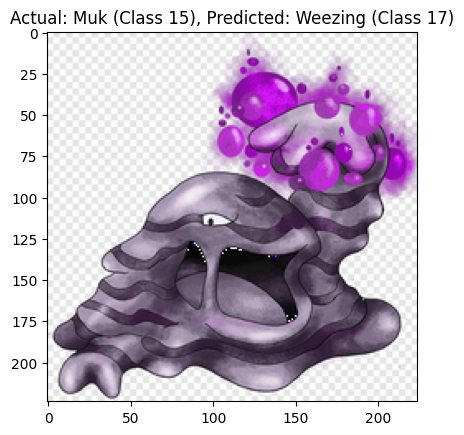

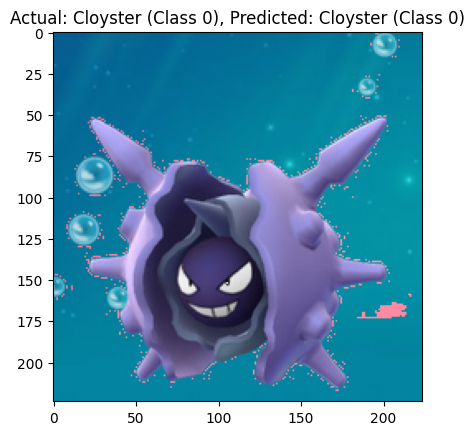

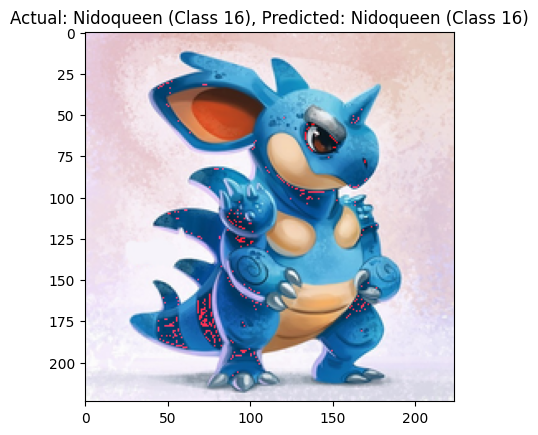

In [10]:
def display_random_image_prediction():
  index_to_display = random.randint(0, len(test_dataset) - 1)
  image, label = test_dataset[index_to_display]
  image = image.unsqueeze(0).to(device)
  logits = model(image.permute(0, 3, 1, 2))
  predicted_label = torch.argmax(logits).item()
  np_image = (image.squeeze().cpu().numpy() * 255).astype(np.uint8)
  np_image = 255 - np_image
  plt.imshow(np_image)
  plt.title(f"Actual: {pokemon_classes[label]} (Class {label}), Predicted: {pokemon_classes[predicted_label]} (Class {predicted_label})")
  plt.show()

display_random_image_prediction()
display_random_image_prediction()
display_random_image_prediction()